In [1]:
# pip install request
# pip install kagglehub
# !pip install pyspark
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas

## Objective
This project demonstrates how to use **PySpark** for reading, transforming, and analyzing a messy credit card transaction dataset. The goal is to:

- Clean and structure the raw data
- Mask personally identifiable information (PII)
- Convert timestamps to Malaysia timezone (UTC+8)
- Perform exploratory data analysis and create visualizations
- Identify and highlight fraud patterns

The dataset was sourced from Kaggle and contains a mix of structured and semi-structured data, requiring careful cleaning and transformation.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Start Spark session
spark = SparkSession.builder \
    .appName("PayNet Credit Card Fraud Detection") \
    .getOrCreate()

# Optional: Check Spark version
print("Spark version:", spark.version)

Spark version: 4.0.0


# Read Json Dataset with Pyspark

In [3]:
df_raw = spark.read.json(r"C:\Users\Afiq Azizi\Desktop\Assesment\Jupyter_Assesment\cc_sample_transaction.json", multiLine=True)

In [4]:
# Read the JSON file
df_raw = spark.read.json(r"C:\Users\Afiq Azizi\Desktop\Assesment\Jupyter_Assesment\cc_sample_transaction.json", multiLine=True)

# Preview the schema
df_raw.printSchema()

# Show a few rows
df_raw.show(5, truncate=False)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Flatten Personel Details Column

In [5]:
from pyspark.sql.functions import from_json, col

# Define schema for personal_detail
personal_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True),
])

# Parse personal_detail
df_parsed = df_raw.withColumn("personal_detail_json", from_json(col("personal_detail"), personal_schema))

# Extract top-level fields
df_extracted = df_parsed \
    .withColumn("person_name", col("personal_detail_json.person_name")) \
    .withColumn("gender", col("personal_detail_json.gender")) \
    .withColumn("lat", col("personal_detail_json.lat")) \
    .withColumn("long", col("personal_detail_json.long")) \
    .withColumn("city_pop", col("personal_detail_json.city_pop")) \
    .withColumn("job", col("personal_detail_json.job")) \
    .withColumn("dob", col("personal_detail_json.dob")) \
    .withColumn("address_json", from_json(col("personal_detail_json.address"), MapType(StringType(), StringType())))

# Extract address fields
df_final = df_extracted \
    .withColumn("street", col("address_json.street")) \
    .withColumn("city", col("address_json.city")) \
    .withColumn("state", col("address_json.state")) \
    .withColumn("zip", col("address_json.zip"))


In [6]:
df_final.select("person_name", "gender", "lat", "long", "job", "dob", "street", "city", "state", "zip").show(5, truncate=False)


+--------------------+------+-------+--------+-------------------------+----------+--------------+--------------+-----+-----+
|person_name         |gender|lat    |long    |job                      |dob       |street        |city          |state|zip  |
+--------------------+------+-------+--------+-------------------------+----------+--------------+--------------+-----+-----+
|Jennifer,Banks,eeeee|F     |36.0788|-81.1781|Psychologist, counselling|1988-03-09|561 Perry Cove|Moravian Falls|NC   |28654|
+--------------------+------+-------+--------+-------------------------+----------+--------------+--------------+-----+-----+



# Clean person_name to Extract First and Last Name

In [7]:
from pyspark.sql.functions import split

# Clean person_name → extract first and last names
df_named = df_final \
    .withColumn("first", split(col("person_name"), ",").getItem(0)) \
    .withColumn("last", split(col("person_name"), ",").getItem(1))


In [8]:
df_named.select("person_name", "first", "last").show(5, truncate=False)


+--------------------+--------+-----+
|person_name         |first   |last |
+--------------------+--------+-----+
|Jennifer,Banks,eeeee|Jennifer|Banks|
+--------------------+--------+-----+



# To check if there is any null records or empty name to remarks

In [9]:
from pyspark.sql.functions import col, length, isnull

# Count null or empty person_name
df_named.select(
    count(when(col("person_name").isNull() | (col("person_name") == ""), "person_name")).alias("null_person_name"),
    count(when(col("first").isNull() | (col("first") == ""), "first")).alias("null_first_name"),
    count(when(col("last").isNull() | (col("last") == ""), "last")).alias("null_last_name")
).show()


+----------------+---------------+--------------+
|null_person_name|null_first_name|null_last_name|
+----------------+---------------+--------------+
|               0|              0|             0|
+----------------+---------------+--------------+



# Convert Timestamp to UTC +8

In [10]:
from pyspark.sql.functions import to_timestamp, from_utc_timestamp

df_time = df_named \
    .withColumn("trans_time_utc8", from_utc_timestamp(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_last_update_time_utc8", from_utc_timestamp(to_timestamp("merch_last_update_time"), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_eff_time_utc8", from_utc_timestamp(to_timestamp("merch_eff_time"), "Asia/Kuala_Lumpur"))


In [11]:
df_time.select("trans_date_trans_time", "trans_time_utc8").show(5, truncate=False)


+---------------------+-------------------+
|trans_date_trans_time|trans_time_utc8    |
+---------------------+-------------------+
|2019-01-01 00:00:18  |2019-01-01 08:00:18|
+---------------------+-------------------+



In [12]:
from pyspark.sql.functions import lit, concat

# Mask credit card number and drop first name
df_pii = df_time \
    .withColumn("cc_num_masked", concat(lit("************"), col("cc_num").substr(-4, 4))) \
    .drop("cc_num", "first")


In [13]:
df_pii.select("cc_num_masked", "last").show(5, truncate=False)


+----------------+-----+
|cc_num_masked   |last |
+----------------+-----+
|************2095|Banks|
+----------------+-----+



In [15]:
from pyspark.sql.functions import from_unixtime, from_utc_timestamp, to_timestamp, col

df_time = df_named \
    .withColumn("trans_time_utc8", from_utc_timestamp(to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss"), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_last_update_time_utc8",
                from_utc_timestamp(from_unixtime(col("merch_last_update_time").cast("long") / 1000), "Asia/Kuala_Lumpur")) \
    .withColumn("merch_eff_time_utc8",
                from_utc_timestamp(from_unixtime(col("merch_eff_time").cast("long") / 1000), "Asia/Kuala_Lumpur"))


In [16]:
from pyspark.sql.functions import count, when

df_time.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_time.columns
]).show(truncate=False)


+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------+---------------------+---------+--------------------+-----------+------+---+----+--------+---+---+------------+------+----+-----+---+-----+----+---------------+---------------------------+-------------------+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|personal_detail|trans_date_trans_time|trans_num|personal_detail_json|person_name|gender|lat|long|city_pop|job|dob|address_json|street|city|state|zip|first|last|trans_time_utc8|merch_last_update_time_utc8|merch_eff_time_utc8|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------+---------------------+---------+--------------------+-----------+------+---+----+--------+---+---+------------+------+----+-----+---+-----+----+

In [17]:
df_time.groupBy("trans_num").count().filter("count > 1").show()


+---------+-----+
|trans_num|count|
+---------+-----+
+---------+-----+



In [18]:
df_time.filter(col("amt").cast("float") <= 0).select("amt", "trans_num").show(5)


+---+---------+
|amt|trans_num|
+---+---------+
+---+---------+



In [19]:
df_time.filter(
    (col("lat").cast("float") < -90) | (col("lat").cast("float") > 90) |
    (col("long").cast("float") < -180) | (col("long").cast("float") > 180)
).select("lat", "long", "trans_num").show(5)


+---+----+---------+
|lat|long|trans_num|
+---+----+---------+
+---+----+---------+



In [20]:
df_vis = df_time.select(
    "amt", "category", "merchant", "city", "state", "gender", "job", "city_pop", "trans_time_utc8", "is_fraud"
).toPandas()


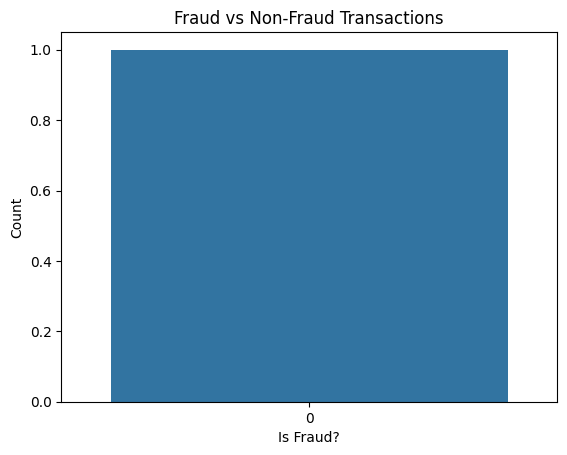

In [21]:
sns.countplot(x="is_fraud", data=df_vis)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Is Fraud?")
plt.ylabel("Count")
plt.show()


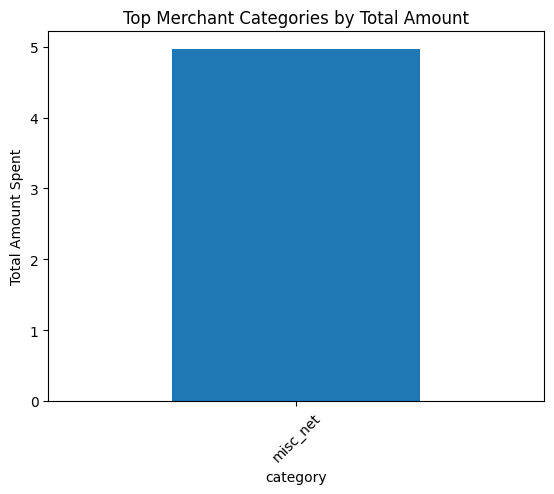

In [24]:
df_vis["amt"] = df_vis["amt"].astype(float)


df_vis.groupby("category")["amt"].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top Merchant Categories by Total Amount")
plt.ylabel("Total Amount Spent")
plt.xticks(rotation=45)
plt.show()


In [29]:
df_vis["trans_time_utc8"] = pd.to_datetime(df_vis["trans_time_utc8"], errors='coerce')

# Count unique dates
print(df_vis["trans_time_utc8"].dt.date.nunique())



1


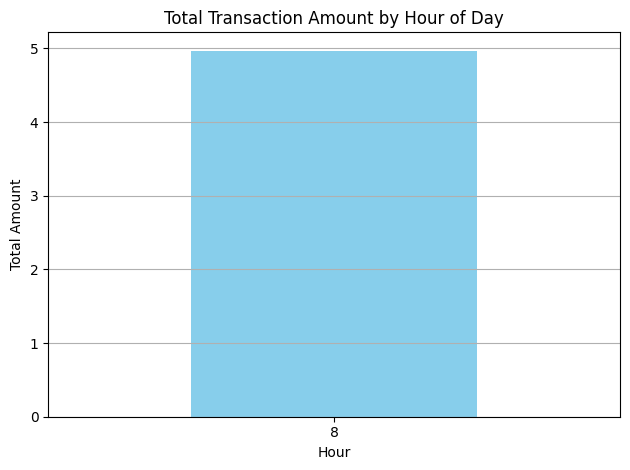

In [31]:
# Extract hour from transaction timestamp
df_vis["hour"] = df_vis["trans_time_utc8"].dt.hour

# Plot total amount by hour
df_vis.groupby("hour")["amt"].sum().plot(kind="bar", color='skyblue')
plt.title("Total Transaction Amount by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Total Amount")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()



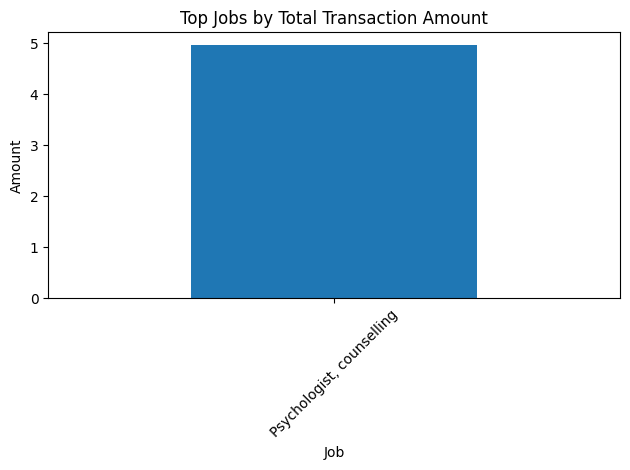

In [34]:
df_vis.groupby("job")["amt"].sum().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top Jobs by Total Transaction Amount")
plt.xlabel("Job")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

